#  [Sec1] forward pretrianed-vggface19 model
## if mem less than 20GB directly go sec2
## read pretrained vgg face model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sess = tf.InteractiveSession()
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [ ]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,])
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded from disk"

graph = tf.get_default_graph()

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser3/train',sess.graph)

In [ ]:
sess.graph.get_operations()[88].values()

In [ ]:
#this will get all operation in graph
sess.graph.get_operations()
#we can get specific operation by
graph.get_tensor_by_name("import/Relu_1:0")

In [ ]:
#what we want is the out come from fc_7
feature_net=graph.get_tensor_by_name("import/pool5:0")


In [ ]:
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

In [ ]:
trial = sess.run([x_tf_1], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(trial[3].astype('uint8'))

# forward pass all pictures

In [ ]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]
feature_x2 = sess.run([feature_net], feed_dict={x_tf:frames[100:200], y_tf: y_train[100:200]})[0]
feature_x3 = sess.run([feature_net], feed_dict={x_tf:frames[200:300], y_tf: y_train[200:300]})[0]
feature_x4 = sess.run([feature_net], feed_dict={x_tf:frames[300:400], y_tf: y_train[300:400]})[0]
feature_x5 = sess.run([feature_net], feed_dict={x_tf:frames[400:500], y_tf: y_train[400:500]})[0]
feature_x6 = sess.run([feature_net], feed_dict={x_tf:frames[500:600], y_tf: y_train[500:600]})[0]
feature_x7 = sess.run([feature_net], feed_dict={x_tf:frames[600:700], y_tf: y_train[600:700]})[0]
feature_x8 = sess.run([feature_net], feed_dict={x_tf:frames[700:800], y_tf: y_train[700:800]})[0]
feature_x9 = sess.run([feature_net], feed_dict={x_tf:frames[800:900], y_tf: y_train[800:900]})[0]
feature_x10 = sess.run([feature_net], feed_dict={x_tf:frames[900:], y_tf: y_train[900:]})[0]

In [ ]:
feature_x=(np.concatenate((feature_x1, feature_x2, feature_x3,
                    feature_x4, feature_x5, feature_x6,
                    feature_x7, feature_x8, feature_x9,
                    feature_x10), axis=0))
print feature_x.shape

In [ ]:
np.save("/home/stream/whimh2.0/finetune",feature_x)

In [ ]:
from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
tf.reset_default_graph()
sess.close()

#  [Sec2] retrain WHIMH
# now train softmax model with (?,7,7,512) features 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
feature_x=np.load("finetune.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
#from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)

In [ ]:
x_tfed = tf.placeholder(tf.float32, shape=[None,7,7,512],name='feature_x')
y_tf = tf.placeholder(tf.int32, shape=[None,],name='truth_y')

In [ ]:
with tf.name_scope('fintune_whimh'):
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        h_pool3_flat = tf.reshape(x_tfed, [-1, 7*7*512])
        W_whimh_fc1 = weight_variable([7*7*512, 1024])
        b_whimh_fc1 = bias_variable([1024])
        h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
        tf.histogram_summary('fc_1/weights', W_whimh_fc1)
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        W_whimh_fc2 = weight_variable([1024, 3])
        b_whimh_fc2 = bias_variable([3])
        y_conv=tf.nn.softmax(tf.matmul(h_fc1, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 
        tf.histogram_summary('fc_2/weights', W_whimh_fc2)
    y_tf_2=tf.one_hot(y_tf,3)
    with tf.name_scope('loss_calulate'):
        #calculate_entropy
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
    with tf.name_scope('regular'):    
        regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                        (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                       )

    with tf.name_scope('loss'):  
        loss=cross_entropy+1e-3*regularizers
    with tf.name_scope('slover'):
        train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)
    with tf.name_scope('measure'):
        with tf.name_scope('predict'):
            predctions=tf.argmax(y_conv,1, name='predictions_')
        with tf.name_scope('groundtruth'):
            ground_truth=tf.argmax(y_tf_2,1)
        correct_prediction = tf.equal(predctions, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        #MHaccuracy
        idxsMH = tf.where(tf.equal(ground_truth, 0))
        correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_conv,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
        accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
        #NMaccuracy
        idxsNM = tf.where(tf.equal(ground_truth, 1))
        correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_conv,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
        accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
        #NHaccuracy
        idxsNH = tf.where(tf.equal(ground_truth, 2))
        correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_conv,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
        accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))

    tf.scalar_summary('accuracy', accuracy)
    tf.scalar_summary('accuracyMH', accuracyMH)
    tf.scalar_summary('accuracyNM', accuracyNM)
    tf.scalar_summary('accuracyNH', accuracyNH)
    #this variable means records all records
    merged = tf.merge_all_summaries()


In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser3/train',sess.graph)
test_writer = tf.train.SummaryWriter('/tmp/loser3/test',sess.graph)

In [ ]:
sess.run(tf.initialize_all_variables())

In [ ]:
k=0
for i in range(500):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:60]
  train_step.run(feed_dict={x_tfed:data['X_train'][idx], y_tf: data['y_train'][idx]})
  if i%10==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    summary, train_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_train'], y_tf: data['y_train']})
    train_writer.add_summary(summary, i)
    ############testing acc#########
    #testing_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_val'], y_tf: data['y_val'], keep_prob: 1.0})
    
    summary, testing_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_val'], y_tf: data['y_val']})
    test_writer.add_summary(summary, i)
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    
#overall
print("test accuracy %g"%accuracy.eval(feed_dict={
    x_tfed:data['X_val'], y_tf: data['y_val']}))

# save models using tf.traing.saver

In [ ]:
#proto
#for sec [3,4]
tf.train.write_graph(sess.graph_def, "/home/stream/whimh2", "pretensorWhimh.pb", False) 
#save weights
saver=tf.train.Saver(tf.all_variables())
saver.save(sess,"PretensorWhimh.ckpt")

# freeze model using ggreeze_graph

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'chkpt', global_step=0, latest_filename='chkpt_state')
tf.train.write_graph(sess.graph.as_graph_def(),"/home/stream/whimh2.0", 'pretensorWhimh.pb', False)

In [ ]:
from freeze_graph import freeze_graph 

In [ ]:
#[i.name for i in sess.graph.get_operations()]

In [ ]:
input_saver_def_path = ''
input_binary=True
input_checkpoint_path = 'chkpt-0'
input_graph_path = 'pretensorWhimh.pb'
output_graph_path = 'pretensorWhimh.pb'
output_node_names = 'fintune_whimh/measure/predict/predictions_'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = True

freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, input_checkpoint_path,
                              output_node_names, restore_op_name,
                              filename_tensor_name, output_graph_path,
                              clear_devices, "")

In [ ]:
tf.reset_default_graph()
sess.close()

# [sec 3] conncate these two models using twice sess.run

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
sess = tf.InteractiveSession()
graph = tf.get_default_graph()

In [ ]:
newsaver=tf.train.import_meta_graph('PretensorWhimh.ckpt.meta')
newsaver.restore(sess,'PretensorWhimh.ckpt')

In [ ]:
graph = tf.get_default_graph()
pool5=graph.get_tensor_by_name("feature_x:0")
results=graph.get_tensor_by_name("fintune_whimh/measure/predict/ArgMax:0")

In [ ]:

with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,],name="turth_y_mh")
feature_x=tf.import_graph_def(graph_def,name='vggface', input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
print "graph loaded from disk"



In [ ]:
sess.graph.get_operations()[0].values()

In [ ]:
#load data
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
print y_train [arr[:10]]
pool_x=sess.run(feature_x, feed_dict={x_tf:frames[arr[:10]]})[0]
sess.run(results, feed_dict={pool5:pool_x})

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser/train',sess.graph)
tf.reset_default_graph()
sess.close()

# [sec 4] conncate these two models using two freeze model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
sess = tf.InteractiveSession()
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,],name="turth_y_mh")

In [ ]:

with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)


In [ ]:
#tf.import_graph_def(gdef_1)
#[i.name for i in sess.graph.get_operations()]

In [ ]:
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)

In [ ]:
with tf.Graph().as_default() as g_combined:
  feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
  #feature
  results=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/measure/predict/predictions_:0"])

In [ ]:
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
print y_train[arr[0:10]]
sess.run(results, feed_dict={x_tf:frames[arr[0:10]]})

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser/train',sess.graph)
tf.reset_default_graph()
sess.close()

# name scope trial

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
y_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")

In [ ]:
[i.name for i in sess.graph.get_operations()]

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser1/train',sess.graph)
tf.reset_default_graph()
sess.close()

# image gradient

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sess = tf.InteractiveSession()

def weight_variable(shape):
  initial = tf.zeros(shape)
  return tf.Variable(initial)


In [2]:
with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)

with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fc92c1ec6d0>> ignored


now :0
now :30
now :60
now :90


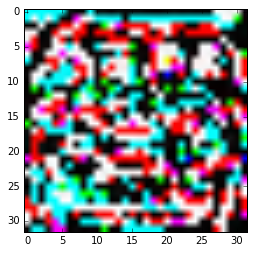

In [3]:
with tf.Graph().as_default() as g_combined:
  input_Image = weight_variable([1,32,32, 3])
  x_tf_1=tf.image.resize_images(input_Image,224,224)
  feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
  y_tf = tf.placeholder(tf.int32, shape=[1,],name="turth_y_mh")
  y_tf_2=tf.one_hot(y_tf,3)
  
  y_conv=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/finetune_layer_1/predictions_softmax:0"])
  cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))+tf.nn.l2_loss(input_Image)*1e-3
  train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(1000):
       sess.run(train_step,feed_dict={y_tf:[0]})
       if i % 30==0:
            print "now :" + str(i)
            x=sess.run(input_Image)
            plt.imshow(x[0].astype('uint8'))
    


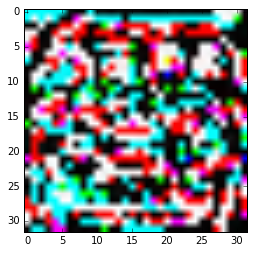

In [4]:
plt.imshow(x[0].astype('uint8'))